# Prepping Data

### Objective: To prep data for further analysis


Our data contains some duplicate information, information which may result in colinearity issues, and missing information. 

We resolve those issues in the below.

## Importing the data

In [2]:
import pandas as pd

In [3]:
### refugee information (inlcuding origin, destination, and year of movement)
refugees = pd.read_csv('/Users/joel/Documents/Brainstation/Tablaeu/immigrantbyorigin.csv')

In [8]:
###Accessing strings representing each country's name.


country_path = '/Users/joel/Documents/Brainstation/Tablaeu/UNINFOKEY/countries.csv'
countries = pd.DataFrame(pd.read_csv(country_path)['country'])
countries.columns=['Country']

In [11]:
### Accessing UN file titles.
key_path = '/Users/joel/Documents/Brainstation/Tablaeu/UNINFOKEY/un_info_key.csv'
key = pd.DataFrame(pd.read_csv(key_path))

In [13]:
### Accessing and collecting the files that will be the dependent variable.

files = key['file']
bank_of_files = []
for file in files:
    list_=[]
    list_.append(file)
    list_.append(pd.read_csv('/Users/joel/Documents/Brainstation/Tablaeu/UNINFO/'+file+'.csv', encoding='ISO-8859-1', header=1))
    bank_of_files.append(list_)

In [6]:
#make bankv2 - a list containing dataframes that only contain information for the five years ended 2015.

bankv2=[]
for name_frame_pair in bank_of_files:
    name = name_frame_pair[0]
    file = name_frame_pair[1]
    header = file.columns
    eleven = '2011' in header
    twelve = '2012' in header
    thirteen = '2013' in header
    fourteen = '2014' in header
    fifteen = '2015' in header
    
    
    if eleven and twelve and thirteen and fourteen and fifteen:
        range_ = ['Country','2011','2012','2013','2014','2015']
        columns_ = ['Country', '2011 '+name,'2012 '+name,'2013 '+name,'2014 '+name,'2015 '+name ]
        list_ = []
        list_.append(name)
        frame = file.loc[:,range_][0:len(file)-1]
        frame.columns = columns_
        list_.append(frame)
        bankv2.append(list_)

In [14]:
#countries to country strings
country_strings = countries.applymap(str)

for dataset in bankv2:
    dataset[1]=dataset[1].applymap(str)
    for index, row in dataset[1].iterrows():
        row['Country']=row['Country'].strip()

In [15]:
#creating a merged DF that contains all tables from the UN
merged = countries
for dataset in bankv2:
    merged = merged.merge(dataset[1], how='left', on='Country')

In [16]:
import numpy as np
# removing all countries for which there's less than half of the data
no_nas=merged.dropna(axis=0, thresh=214)

#removing all dimensions for which there's more than 20 nulls
no_nas = no_nas.dropna(axis=1, thresh=162)
path = '/Users/joel/Documents/Brainstation/Tablaeu/UNOUTS/nullsums.csv'
a = pd.DataFrame(no_nas.isnull().sum().sort_values(ascending=False)).loc['2015 Equality8':].index

In [17]:
#the columns for which no more than 20 'nans' are included
inds = pd.DataFrame(no_nas.isin(['nan']).sum().sort_values(ascending=False)).loc['2013 Income7':,:].index

In [58]:
#creating no_nas2 - a DF which is relatively clean (no more than 20 nans or NaNs per column)
no_nas2 = no_nas.loc[:,inds]

In [20]:
#making no_nas3 - a DF where all residual NaNs and 'nans'
def make_int(x):
    if x=='nan':
        return float(0.123456789)
    if x in countries['Country'].tolist():
        return x
    else:
        return float(x)

no_nas3 = no_nas2.applymap(make_int)

#putting in place of NaN - 0.123456789 which we'll repalce later
no_nas4 = no_nas3.fillna(0.123456789)

In [21]:
#replace all floats of value 0.123456789 with the mean for the respective values column.

for column in no_nas4.columns.tolist():
   
    sum_=0.0
    n_=0.0
    mean=0
    for index in no_nas4.index:
        
        if no_nas4.loc[index,column] == 0.123456789:
            
            pass
        elif no_nas4.loc[index,column] in countries['Country'].tolist():
            pass
        else:
            
            sum_+=no_nas4.loc[index,column]
            n_+=1
    
    if column == 'Country':
        pass
    else:
        mean +=sum_/n_
        
    for index in no_nas4.index:
        if no_nas4.loc[index,column] == 0.123456789:
            no_nas4.loc[index,column]=mean
        
    

In [23]:
#no_nas4 is now a clean dataset with 181 countries and 257 fields

#now remove any for which there are not a pair of 5 years of info

from collections import Counter

list_ = []

for i in no_nas4.columns:
    list_.append(i[5:])

In [25]:
#make no_nas5 which is a clean DF with only fields that have 5 years worth of information
to_remove = []
for i in no_nas4.columns:
    if 'Trade2' in i or 'Income2' in i or 'Work1' in i or 'Trade7' in i or 'Income7' in i or 'Equality5' in i or 'Equality8' in i:
        to_remove.append(i)

no_nas5 = no_nas4.drop(to_remove, axis=1)

In [27]:
#Here's the data
refugees = pd.read_csv('/Users/joel/Documents/Brainstation/Tablaeu/REFUGEEDATA/immigrantbyorigin.csv')

Text(0.5,1,'Annual Refugee Arrivals in USA')

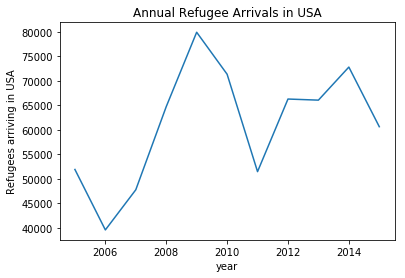

In [29]:
#Using the refugees DF, group by country by year.
import numpy as np
from pandas import pivot_table
from matplotlib import pyplot as plt

table = pivot_table(refugees, values='arrivals', index='origin',columns='year', aggfunc=np.sum)
table2 = pivot_table(refugees, values = 'arrivals', index = 'dest_city', aggfunc = np.sum)

years = []
sums_=[]
for year in table.columns:
    sums_.append(table[year].sum())
    years.append(year)

plt.plot(years, sums_)
plt.xlabel('year')
plt.ylabel('Refugees arriving in USA')
plt.title('Annual Refugee Arrivals in USA')

In [30]:
#no_nas6 has all years but sorted by year
list__ = no_nas5.columns
list__ = sorted(list__)
no_nas6 = no_nas5.loc[:,list__]

In [33]:
### We're going to group all headings by year so that we can stack the 2012 variables below the 2011 variables
### and the 2013 variables under the 2012 variable. etc. 
eleven = ['Country']
twelve = ['Country']
thirteen = ['Country']
fourteen = ['Country']
fifteen = ['Country']

for column in no_nas6.columns:
    if '2011' in column:
        eleven.append(column)
    elif '2012' in column:
        twelve.append(column)
    elif '2013' in column:
        thirteen.append(column)
    elif '2014' in column:
        fourteen.append(column)
    elif '2015' in column:
        fifteen.append(column)

In [34]:
### Vertically stacking the dependent variable by year.
left = no_nas6.loc[:,eleven]

In [37]:
### Setting up a pivot table for the refugee arrival data to be merged to the country data.

from pandas import pivot_table

pivot = pivot_table(refugees, values = 'arrivals', index='origin', columns='year', aggfunc='sum')
pivot.head(3)
right = pivot


In [39]:
### Dropping variables that result in colinearity, that are duplicates, or that we don't have 5 years of info for.
env2 = ['2011 Environment2', '2012 Environment2', '2013 Environment2', '2014 Environment2', '2015 Environment2']
sec2 = ['2011 Security2', '2012 Security2', '2013 Security2', '2014 Security2', '2015 Security2']
wk6 = ['2011 Work6', '2012 Work6', '2013 Work6', '2014 Work6', '2015 Work6']
wk7 = ['2011 Work7', '2012 Work7', '2013 Work7', '2014 Work7', '2015 Work7']
sec1 = ['2011 Security1', '2012 Security1', '2013 Security1', '2014 Security1', '2015 Security1']

all_ = env2+sec2+wk6+wk7+sec1

no_nas7=no_nas6.drop(all_, axis=1)


In [46]:
#Listing out the countries that are not common to both DFs 
refs = pivot
to_resolve = []

for country in refs.index:
    if country in list(no_nas7.loc[:,'Country']):
        pass
    else:
        to_resolve.append(country)

In [47]:
#replacing countries that need to be replace
solved = [
    'Burkina Faso',
    'Myanmar',
    'Congo (Democratic Republic of the)',
    'Gaza Strip',
    'Guinea-Bissau',
    'Iran (Islamic Republic of)',
    "Côte d'Ivoire",
    'Korea, North',
    "Lao People's Democratic Republic",
    'The former Yugoslav Republic of Macedonia',
    'Madagascar',
    'Moldova (Republic of)',
    'Palestine',
    'South Sudan',
    'Russian Federation',
    'Somalia',
    'Sri Lanka',
    'Syrian Arab Republic',
    'Tanzania (United Republic of)',
    'Tibet',
    'Venezuela (Bolivarian Republic of)',
    'Viet Nam'
]

solved_dict = {}

for index in range(len(to_resolve)):
    solved_dict[to_resolve[index]] = solved[index]

In [49]:
### Make a list of countries so that you can add it to the refs table

new_ref_countries = []

for country in refs.index:
    if country in solved_dict.keys():
        new_ref_countries.append(solved_dict[country])
    else:
        new_ref_countries.append(country)

refs['Country']=new_ref_countries

bad_countries = []

for country in list(refs['Country']):
    if country in list(no_nas7['Country']):
        pass
    else:
        bad_countries.append(country)
            

In [51]:
### Now replacing country names so that they're commong to both DFs
refugees
pre_pivot_countries = []

for i in refugees.index:
    if refugees.loc[i,'origin'] in solved_dict.keys():
        pre_pivot_countries.append(solved_dict[refugees.loc[i,'origin']])
    else:
        pre_pivot_countries.append(refugees.loc[i,'origin'])
refugees['Country'] = pre_pivot_countries
refugees.head(2)
    

,year,origin,dest_state,dest_city,arrivals,Country
0,2005,Afghanistan,Alabama,Mobile,0,Afghanistan
1,2006,Afghanistan,Alabama,Mobile,0,Afghanistan


In [52]:
column_years = []


for i in range(len(no_nas7.columns)):
    if no_nas7.columns[i][:4] in column_years:
        pass
    else:
        column_years.append([i, no_nas7.columns[i][:4]])

In [54]:
### Stacking variables vertically by year

a1 = ['Country']+list(no_nas7.columns)[0:40]
a2 = ['Country']+list(no_nas7.columns)[40:80]
a3 = ['Country']+list(no_nas7.columns)[80:120]
a4 = ['Country']+list(no_nas7.columns)[120:160]
a5 = ['Country']+list(no_nas7.columns)[160:200]

a1x = no_nas7.loc[:,a1]

headers = ['Country']
for column in a1x.columns[1:]:
    headers.append(column[5:])

a1x.columns = headers
a1x['year']=2011
        

a2x = no_nas7.loc[:,a2]

headers = ['Country']
for column in a2x.columns[1:]:
    headers.append(column[5:])

a2x.columns = headers
a2x['year']=2012

a3x = no_nas7.loc[:,a3]

headers = ['Country']
for column in a3x.columns[1:]:
    headers.append(column[5:])

a3x.columns = headers
a3x['year']=2013

a4x = no_nas7.loc[:,a4]

headers = ['Country']
for column in a4x.columns[1:]:
    headers.append(column[5:])

a4x.columns = headers
a4x['year']=2014

a5x = no_nas7.loc[:,a5]

headers = ['Country']
for column in a5x.columns[1:]:
    headers.append(column[5:])

a5x.columns = headers
a5x['year']=2015

anx = a1x.append(a2x).append(a3x).append(a4x).append(a5x)
anx = anx.reset_index(drop=True)

In [56]:
### Merging both DFs to make the final csv. 

refugees_pivot = pd.pivot_table(refugees, values = 'arrivals', index = ['Country', 'year'], columns='dest_state', aggfunc='sum').fillna(0)

final_merged = anx.merge(refugees_pivot,on=['Country','year'], how='left').fillna(0)

In [57]:
# final_merged.to_csv('/Users/joel/Documents/Brainstation/Tablaeu/CL')